In [31]:
from dotenv import load_dotenv
load_dotenv()

True

In [32]:
from typing_extensions import List, TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list    
    answer : str
    
graph_builder = StateGraph(AgentState)

In [33]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o', streaming=True)
small_llm = ChatOpenAI(model='gpt-4o-mini', streaming=True)


In [34]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

class Route(BaseModel):
    target: Literal['income_tax', 'llm', 'real_estate_tax'] = Field(
        description="The target for the query to answer"
    )
    
router_system_prompt = """
You are an expert at routing a user's question to 'income_tax', 'llm', or 'real_estate_tax'.
'income_tax' contains information about income tax up to December 2024.
'real_estate_tax' contains information about real estate tax up to December 2024.
if you think the question is not related to either 'income_tax' or 'real_estate_tax';
you can route it to 'llm'.
"""

router_prompt = ChatPromptTemplate.from_messages([
    ("system", router_system_prompt),
    ("user", "{query}"),
])    

structured_router_llm = small_llm.with_structured_output(Route)

#분기할 수 있는 함수
def router(state: AgentState) -> Literal['income_tax', 'llm', 'real_estate_tax']:
    """
    주어진 state에서 쿼리를 기반으로 적절한 경로를 결정합니다. 
    Args:
        state (AgentState): 에이전트 현재 상태를 나타내는 딕셔너리.

    Returns:
        Literal['income_tax', 'llm', 'real_estate_tax']: 쿼리에 따라 선택된 경로를 반환합니다. 
    """
    query = state['query']
    router_chain = router_prompt | structured_router_llm
    router = router_chain.invoke({'query': query})
    
    return router.target
    

In [35]:
from langchain_core.output_parsers import StrOutputParser
def call_llm(state: AgentState) -> AgentState:
    """
    주어진 state에서 쿼리를 기반으로 LLM을 호출하여 답변을 생성합니다. 

    Args:
        state (AgentState): 에이전트의 현재 상태를 나타내는 딕셔너리 

    Returns:
        AgentState: 'answer'키에 LLM의 응답을 포함하는 AgentState를 반환합니다. 
    """
    
    query = state['query']
    llm_chain = small_llm | StrOutputParser()
    answer = llm_chain.invoke(query) #{"query": query}
    
    return {'answer': answer}

In [36]:
from income_tax_graph import graph as income_tax_agent
from real_estate_tax_graph import graph as real_estate_tax_agent


graph_builder.add_node('income_tax', income_tax_agent)
graph_builder.add_node('real_estate_tax', real_estate_tax_agent)
graph_builder.add_node('llm', call_llm)

In [37]:
#edge

from langgraph.graph import START, END

graph_builder.add_conditional_edges(
    START,
    router,
    {
        #"리턴값": "노드이름",
        "income_tax" : "income_tax",
        "real_estate_tax": "real_estate_tax",
        "llm": "llm",
    }
)

graph_builder.add_edge('income_tax',END )
graph_builder.add_edge('real_estate_tax', END)
graph_builder.add_edge('llm', END)

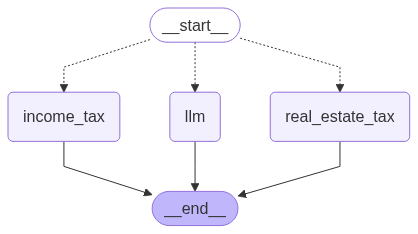

In [38]:
graph = graph_builder.compile()
graph

In [39]:
initial_state = {'query': '연봉 5천만원 거주자의 소득세는 얼마인가요?'}
graph.invoke(initial_state)


{'query': '연봉 5천만원 거주자의 소득세는 얼마인가요?',
 'context': [Document(metadata={'source': './tax.docx'}, page_content='제55조(세율) ①거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 “종합소득산출세액”이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>\n\n| 종합소득 과세표준          | 세율                                         |\n\n|-------------------|--------------------------------------------|\n\n| 1,400만원 이하     | 과세표준의 6퍼센트                             |\n\n| 1,400만원 초과     5,000만원 이하     | 84만원 + (1,400만원을 초과하는 금액의 15퍼센트)  |\n\n| 5,000만원 초과   8,800만원 이하     | 624만원 + (5,000만원을 초과하는 금액의 24퍼센트) |\n\n| 8,800만원 초과 1억5천만원 이하    | 1,536만원 + (8,800만원을 초과하는 금액의 35퍼센트)|\n\n| 1억5천만원 초과 3억원 이하         | 3,706만원 + (1억5천만원을 초과하는 금액의 38퍼센트)|\n\n| 3억원 초과    5억원 이하         | 9,406만원 + (3억원을 초과하는 금액의 38퍼센트)   |\n\n| 5억원 초과      10억원 이하        | 1억 7,406만원 + (5억원을 초과하는 금액의 42퍼센트)|\n\n| 10억원 초과        | 3억 8,406만원 + (10억원을 초과하는 금액의 45퍼센트)|\n\n\n\n\n\n② 거주자의 퇴직소득에 대한 소득세는 다음 

In [40]:
initial_state = {'query': '집 15억은 세금이 얼마인가요?'}
graph.invoke(initial_state)

{'query': '집 15억은 세금이 얼마인가요?',
 'answer': '종합부동산세를 계산하기 위해서는 과세표준을 정확히 알아야 하지만, 공제액 정보가 필요합니다. 일반적으로 주택 소유자에게 적용되는 공제액은 소유한 주택의 수에 따라 달라질 수 있습니다.\n\n1. **공정시장가액**: 이미 계산된 바와 같이, 주택의 공정시장가액은 6.75억 원입니다.\n\n2. **과세표준**: 이 값을 알기 위해 공제액이 필요합니다. 일반적으로 1세대 1주택자의 경우 공제액이 크지만, 다주택자의 경우 다르게 적용될 수 있습니다.\n\n3. **세율**: 주택 수와 과세표준에 따라 차등 적용됩니다. 다주택자의 경우 세율이 더 높게 설정되어 있습니다.\n\n정확한 종합부동산세를 계산하기 위해서는:\n- 주택 수에 따른 공제액 정보\n- 해당 과세표준 구간에 따른 세율 정보\n\n이 두 가지가 필요하므로, 세무사와 상담하거나 정부의 공식 자료를 참조하시길 권장합니다. 그러나 일반적으로, 다주택자는 1.2%에서 6.0% 사이의 세율이 적용될 수 있습니다. 세율표와 공제액 정보를 확인한 후 정확한 세액을 산출하실 수 있습니다.'}

In [41]:
initial_state = {'query': '떡볶이 어디가 맛있나요?'}
graph.invoke(initial_state)

{'query': '떡볶이 어디가 맛있나요?',
 'answer': '떡볶이는 한국의 대표적인 길거리 음식으로, 지역마다 맛집이 많이 있습니다. 서울에서는 **신당동 떡볶이 골목**이 유명하고, **홍대**와 **강남** 지역에도 맛있는 떡볶이 집들이 많이 있습니다. 부산에서는 **자갈치 시장** 근처의 떡볶이도 추천할 만합니다. 개인의 취향에 따라 매운맛이나 소스의 종류가 다르기 때문에, 여러 곳을 시도해보는 것도 좋은 방법입니다. 특정 지역이나 스타일에 대한 추천이 필요하시면 말씀해 주세요!'}